In [1]:
plt.style.use('bmh')
# plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

### Windows description

#### 1. Read datasets

In [2]:
# Read clean dataset
feats = [
    'Property_UPRN',
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
df0 = pd.read_csv('data/data_clean.csv')[feats]
# create rating
df0['CO2_rating'] = pd.qcut(df0[feats[-1]], q = 5, labels = range(1,6)).astype(int)
df0['CO2_rating'] = 6 - df0.CO2_rating
display(df0.CO2_rating.value_counts().sort_index())

1    36938
2    34265
3    37728
4    37016
5    39092
Name: CO2_rating, dtype: int64

In [3]:
# read preprocessed dataset
df1 = pd.read_csv('data/descriptions/WINDOWS_DESCRIPTION.csv', sep = '|')
# ratings convertion and merge with initial dataset
dict_repl1 = {
    'very poor': 1,
    'poor': 2,
    'average': 3,
    'good': 4,
    'very good': 5,
}
df1['Windows_rating'] = df1['WINDOWS_ENERGY_EFF'].str.lower().map(dict_repl1)
df1 = df1.merge(df0, on = 'Property_UPRN', how = 'left')
df1['Total_rating'] = (df1.Windows_rating + df1.CO2_rating)/2
print(df1.shape)
display(df1.Total_rating.value_counts().sort_index())

(185039, 9)


1.00     2872
1.50     3258
2.00    25586
2.50    32430
3.00    33208
3.50    30573
4.00    21429
4.50    13816
5.00    21867
Name: Total_rating, dtype: int64

#### 2. Data cleaning

In [4]:
df1['WINDOWS_DESCRIPTION'] = df1.WINDOWS_DESCRIPTION.str[13:]

In [5]:
df1.WINDOWS_DESCRIPTION.value_counts().to_dict()

{'Fully double glazed': 146947,
 'High performance glazing': 22638,
 'Single glazed': 6578,
 'Partial double glazing': 2711,
 'Mostly double glazing': 2496,
 'Some double glazing': 1423,
 'Fully triple glazed': 1218,
 'Full secondary glazing': 441,
 'Partial secondary glazing': 248,
 'Mostly secondary glazing': 92,
 'Some secondary glazing': 91,
 'Multiple glazing throughout': 68,
 'Mostly multiple glazing': 33,
 'Partial triple glazing': 20,
 'Partial multiple glazing': 17,
 'Mostly triple glazing': 14,
 'Some multiple glazing': 3,
 'Some triple glazing': 1}

In [6]:
dict_repl = {
    'Fully double glazed':         'Fully double glazed',
    'High performance glazing':    'High performance glazing',
    'Single glazed':               'Single glazed',
    'Partial double glazing':      'Partial double glazing',
    'Mostly double glazing':       'Mostly double glazing',
    'Some double glazing':         'Partial double glazing',
    'Fully triple glazed':         'Triple glazed',
    'Full secondary glazing':      'Fully double glazed',
    'Partial secondary glazing':   'Partial double glazing',
    'Mostly secondary glazing':    'Mostly double glazing',
    'Some secondary glazing':      'Partial double glazing',
    'Multiple glazing throughout': 'Multiple glazing',
    'Mostly multiple glazing':     'Multiple glazing',
    'Partial triple glazing':      'Triple glazed',
    'Partial multiple glazing':    'Multiple glazing',
    'Mostly triple glazing':       'Triple glazed',
    'Some multiple glazing':       'Multiple glazing',
    'Some triple glazing':         'Triple glazed',
}
df1['WINDOWS_DESCRIPTION'] = df1.WINDOWS_DESCRIPTION.map(dict_repl)

In [7]:
df1[:3]

,WINDOWS_DESCRIPTION,WINDOWS_ENERGY_EFF,Property_UPRN,Windows_rating,Current energy efficiency rating,Total current energy costs over 3 years (£),CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr),CO2_rating,Total_rating
0,Fully double glazed,Average,1001100841,3,53.00,"3,789.00",66.00,1,2.00
1,Fully double glazed,Average,1001950838,3,66.00,"4,635.00",44.00,3,3.00
2,Single glazed,Very Poor,1000995515,1,61.00,"3,570.00",68.00,1,1.00


#### 3. Ratings vizualisation

In [8]:
feats_gr = ['WINDOWS_DESCRIPTION']
feats_ag = ['Windows_rating', 'CO2_rating', 'Total_rating']
colors_list = ['red','orange','green']

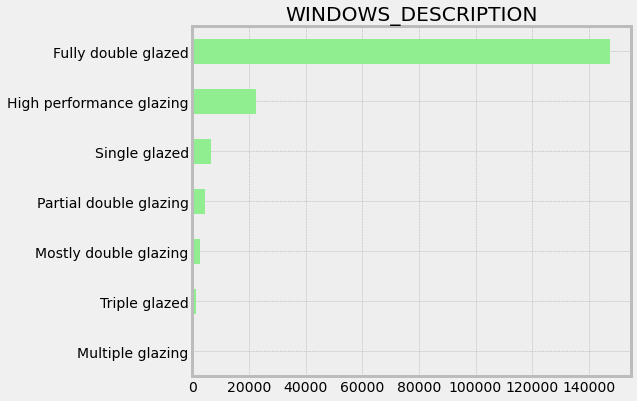

In [9]:
# popularity by wall types and insulation
_, ax = plt.subplots(1,1, figsize = (7,6))
_ = df1.groupby(feats_gr[0]).size().sort_values().plot(kind = 'barh', ax = ax, ylabel = '', color = 'lightgreen', title = 'WINDOWS_DESCRIPTION')

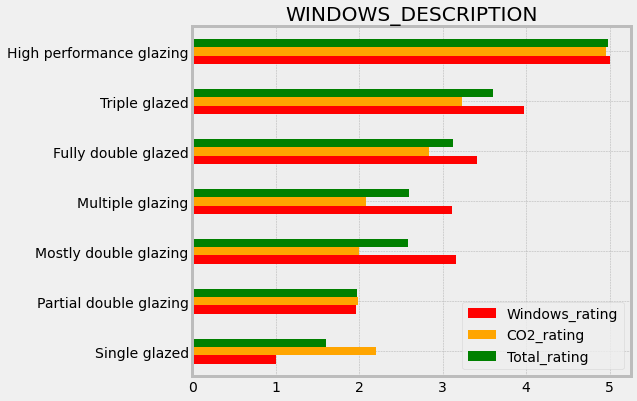

In [10]:
# ratings by wall types and insulation
_, ax = plt.subplots(1,1, figsize = (7,6))
_ = df1.groupby(feats_gr[0])[feats_ag].mean().sort_values('Total_rating').plot(kind = 'barh', ax = ax, ylabel = '', color = colors_list, title = 'WINDOWS_DESCRIPTION')

#### 4. Correlations algorithm

In [11]:
# 1) create splittings
feats_gr = [
    'WINDOWS_DESCRIPTION', 
    'Windows_rating'
]
feats_ag = [
    'Current energy efficiency rating',
    'Total current energy costs over 3 years (£)',
    'CO2 Emissions Current Per Floor Area (kg.CO2/m²/yr)'
]
           
df2 = df1.groupby(feats_gr)[feats_ag[-1]].agg([len,np.mean]).reset_index()
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2['len'] < 100, 'group_name'] = '_OTHER'
del df2['len']
del df2['mean']
print(df2.shape)

# merge with initial dataset
df1 = df1.merge(df2, how = 'left', on = feats_gr)

(23, 3)


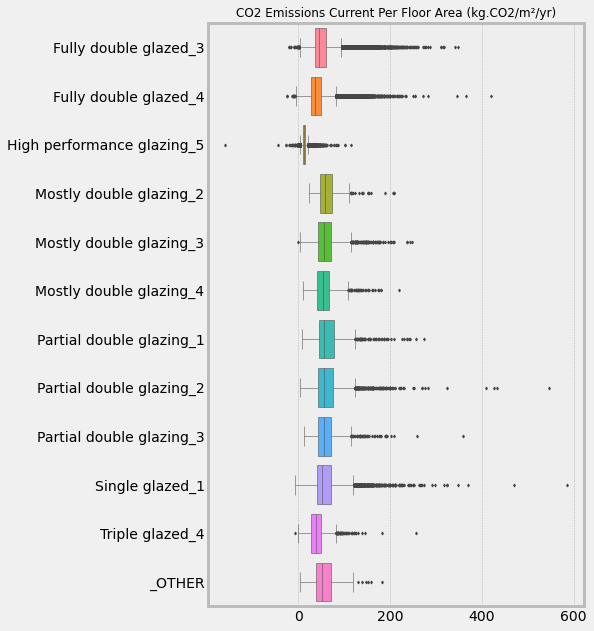

In [12]:
# 2) Plot boxplot to visually compare distributions
list_groups = sorted(df1[~df1.group_name.isnull()].group_name.unique())
feat = feats_ag[-1]
_, ax = plt.subplots(1,1, figsize = (6,10))
p = sns.boxplot(y=df1.group_name, x=df1[feat], ax = ax, order = list_groups, linewidth=0.5, saturation=1, fliersize = 2)
_ = p.set_title(feat, fontsize = 12)
_ = p.set_ylabel('')
_ = p.set_xlabel('')

In [13]:
# 3) Conduct ANOVA statistical test to have numerical value of similarity between these variables.
from scipy import stats
data = df1.groupby('group_name')[feat].agg(lambda x: list(x))
fvalue, pvalue = stats.f_oneway(*data)
fvalue, pvalue

(5578.163010320191, 0.0)

#### 5. Feature engineering for modelling part
- Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups that described above.
- Create new features on the Property_UPRN level and replace the categorical features by that new numericals.
- We will use that features in the modelling part.

In [14]:
# Calculate average values of features Current energy efficiency rating and Total current energy costs over 3 years (£) by the groups.
pre = 'Windows_'
df2 = df1.groupby(feats_gr)[feats_ag[:-1]].agg([len, np.mean])
df2.columns = [pre+'eff_len',pre+'eff_mean',pre+'cost_len',pre+'cost_mean']
df2.reset_index(inplace = True)
df2['group_name'] = df2[feats_gr].apply(lambda x: '_'.join([str(x1) for x1 in x]), axis = 1)
df2.loc[df2[pre+'eff_len'] < 100, 'group_name'] = '_OTHER'
del df2[pre+'eff_len']
del df2[pre+'cost_len']

In [15]:
# Create new features on the Property_UPRN level and replace the categorical features by that new numericals
df2 = df2.groupby('group_name')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()
df1 = df1.merge(df2)
df3 = df1.groupby('Property_UPRN')[pre+'eff_mean',pre+'cost_mean'].mean().reset_index()

In [16]:
# We will use that features in the modelling part.
df3.to_csv('data/features/WINDOWS_DESCRIPTION.csv', index = False, encoding = 'utf8', sep = '|')